In [1]:
from typing import Any, Callable, NamedTuple, Tuple, Union
Step = int
Schedule = Callable[[Step], float]

from IPython import display
from IPython.display import Image, clear_output
from PIL import Image
import glob, os, shutil
import os.path

from collections import namedtuple

import time

import scipy.io as io
from scipy import sparse as sp
import scipy.sparse.csgraph as csgraph
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
from scipy.stats import gaussian_kde
from scipy.linalg import null_space

import jax
from jax import jit, vmap, random, grad, value_and_grad, hessian
from jax.experimental import optimizers, sparse
from jax.experimental.optimizers import optimizer
from jax import numpy as jnp

from functools import partial
import itertools

import math
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc

import seaborn as sns

import datetime
from tqdm.notebook import tqdm

import networkx as nx

%load_ext autoreload
%autoreload 2

/home/orange3xchicken/.local/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [2]:
import utils
from utils import *
from optimizers import *
from opt_widgets import *

In [3]:
# load the data from the SuiteSparse Matrix Collection format
# https://www.cise.ufl.edu/research/sparse/matrices/
graphs = ['qh882','dwt_1005','3elt','commanche_dual','bcsstk31']
graphdir = './testcases/'
graphpostfix = 'dwt_1005'
assert graphpostfix in graphs
grid_testcase = nx.grid_graph(dim=(50, 50))
#grid_testcase = nx.triangular_lattice_graph(25,25)
grid_testcase = nx.cycle_graph(100)
grid_testcase_adjacency = nx.adjacency_matrix(grid_testcase).toarray().astype(np.int16)
DEBUG=True
if DEBUG:
    graph, G, A, L, D, n = load_graph(graphdir+graphpostfix, A=grid_testcase_adjacency, plot_adjacency=False, verbose=True)
else:
    graph, G, A, L, D, n = load_graph(graphdir+graphpostfix, A=None, plot_adjacency=False, verbose=True)


Name: 
Type: Graph
Number of nodes: 2500
Number of edges: 4900
Average degree:   3.9200


In [4]:
del G
del A
del D

In [5]:
def newton(opt_tuple, A, Ax, Ay, P, L, C, E_0, maxiters=100, beta=0.9):
    """Perform iterations of PND + backtracking line search."""    
    opt_state, opt_update, get_params = opt_tuple    
    X_k = get_params(opt_state)
    step_sizes = 1.0*jnp.power(beta,jnp.linspace(0,100)) # geometric progression
   
    pAp, pAxp, pAyp = P@A@P.T, P@Ax@P.T, P@Ay@P.T 
    L = L_init(X_k, C, pAp, E_0)
    
    newton_trace = init_trace()
    
    def _line_search(s, X_k, Z):
        X_k_t = X_k - s*(-Z)
        X_k_t = project(X_k_t, C, E_0)
        f_xp = f(X_k_t, pAxp, pAyp, E_0)
        return f_xp
    
    for k in tqdm(range(maxiters)):         
        Z, Del = sqp(pAp, L, E_0, X_k)

        f_x = f(X_k, pAxp, pAyp, E_0)
        
        _f_ks = vmap(_line_search,in_axes=(0,None,None))(step_sizes,X_k,Z)
        _f_kamin = jnp.argmin(_f_ks.real)
        f_xp = _f_ks[_f_kamin]
        stp = step_sizes[_f_kamin]
        
        X_k = X_k -stp*(-Z)
        X_k = project(X_k, C, E_0)
                
        L = L + stp*Del
        foc = np.asarray(foc_sqp(X_k, L, C, pAp, E_0))

        newton_trace = update_trace(newton_trace, [f_xp.item()], [stp.item()], 
                                    [(foc, foc)], 
                                    [(foc, foc)], [np.asarray(X_k)], [np.asarray(L)], [None])
            
    return newton_trace

def ssm(opt_tuple, params, C, maxiters=10, beta=0.9):
    """1. compute newton direction z = sqp(X, Z, v, Ax + E0) & subspace S
       2. approximate locally optimal X, L on S; X = min F(\hat{X}, B, V.T@E0)"""
    opt_state, opt_init, opt_update, get_params = opt_tuple
    A, L, E_0, v_s = params['A'], params['L'], params['E_0'], params['v']
    X_0 = get_params(opt_state)
    PE_0 = PX(v_s,E_0)
    I = sp_eye(A.shape[0])
    
    ssm_trace = init_trace()
    
    results = None
    v = X_0    
    
    X_0_proj = project(X_0, C, E_0)
    X_k = X_0_proj
    _project = jit(project)
    for k in tqdm(range(maxiters)):     
        Z, Del = scipy_sqp(X_k, A, None, L, PE_0, I)
        Q,v = subspace(X_k, Z, v, A, PE_0, C)

        QP = XP(Q.T, v_s)
        QX_k = Q.T@X_k
        QPE_0 = Q.T@PE_0
        
        # currently being recompiled. need to fix
        #opt_init, opt_update, get_params = psgd(partial(lambda x, y, z: project(z, y, x), 
        #                                        QPE_0, C)) 
        #opt_init, opt_update, get_params = psgd(partial(lambda x, y, z: z, 
        #                                                E_0, C))  

        opt_state = opt_init(QX_k)  

        newton_trace = newton((opt_state, opt_update, get_params), A,A,A, QP, L, C, QPE_0, 
                               maxiters=50, beta=0.9)         

        argmin_loss = np.argmin(newton_trace['loss'])
        X_k = newton_trace['solution_path'][argmin_loss]
        L = newton_trace['lagrangian'][argmin_loss]
        
        X_k = Q@X_k
        #X_k_p = project(X_k, C, PE_0)
        
        ssm_trace = update_trace(ssm_trace, newton_trace['loss'], newton_trace['step_size'], 
                                 newton_trace['opt_conditions'], 
                                 newton_trace['constraints'], newton_trace['solution_path'], 
                                 newton_trace['lagrangian'], [np.asarray(Q)]*len(newton_trace['loss']))

    argmin_loss = np.argmin(ssm_trace['loss'])
    X_k = ssm_trace['solution_path'][argmin_loss]
    Q = ssm_trace['subspaces'][argmin_loss]
    X_k = Q@X_k
    #X_k_p = project(X_k, C, PE_0)
    return X_k, PE_0, ssm_trace

In [6]:
def create_problem(rng, A, X, v, mask):
    """takes problem parameters returns a params tuple = instance of problem """
    def _compute_problem_vars(A, X, mask):
        """Computes Laplacian decomposition, linear terms in the objective"""
        X_1 = X[~mask]
        A_12 = A[~mask, :][:, mask]

        A = sparse.BCOO.from_scipy_sparse(A[mask, :][:,mask])
        
        print('rqi...')
        eigenvectors, eigenvalues = rqi(A, eps=1e-5, s=0.0)
        print('eigenvalues: ', np.round(np.array(eigenvalues.real), decimals=5))

        X0 = complete_matrix(eigenvectors[:,:2], X_1, mask)
        E_0 = (X_1.T@A_12).T

        return A, X0, E_0
    
    A, X0, E_0 = _compute_problem_vars(A, X, mask)
    params = init_params(A, A, A, X0, mask, E_0, v)
    return params

def solve_problem(rng, opt_params, params, C):
    opt_init, opt_update, get_params = opt_params
    X_0 = params['X'][params['mask']]
    opt_state = opt_init(X_0)
    opt_tuple = (opt_state, opt_init, opt_update, get_params)
    print('ssm...')
    X_k_p, PE_0, ssm_trace = ssm(opt_tuple, params, C, maxiters=10, beta=0.9)
    X = complete_matrix(X_k_p, params['X'][~params['mask']],params['mask'])
    return X, PE_0, ssm_trace

In [7]:
seed = 0 # random seed
eps = 1e-8 # global epsilon variable
rng = random.PRNGKey(seed)
key, subkey = jax.random.split(rng)

c1 = c2 = n*10**2*1/12
c3=0
C = jnp.block([[c1, c3],[c3, c2]])

X_k_r = (random.normal(subkey, (n,2))*np.sqrt(10))

if DEBUG:
    fixed_indices = np.array([0])
    X_k_r = X_k_r.at[0,0].set(0)
    X_k_r = X_k_r.at[0,1].set(-2)
else:
    fixed_indices = np.array([0,1,2,3,4,5,6,7,8,9,10])
    X_k = np.array(X_k_r)
X_k_r = X_k_r.at[0,0].set(0)
X_k_r = X_k_r.at[0,1].set(-5)
X_k = np.array(X_k_r)

In [8]:
mask = jnp.ones((X_k.shape[0],),dtype=bool)
mask = mask.at[fixed_indices].set(False)
v = np.ones((mask.sum(),1))/np.sqrt(mask.sum())
params = create_problem(rng, L, X_k, v, mask)
opt_tuple = psgd(partial(lambda x, y, z: project(z, y, x), 
                         np.zeros((8,2)), C))
X, PE_0, trace = solve_problem(rng, opt_tuple, params, C)

rqi...
eigenvalue 1: 0.004
eigenvalue 2: 0.005
eigenvalues:  [0.00395 0.00463]
ssm...


  0%|          | 0/10 [00:00<?, ?it/s]

/home/orange3xchicken/.local/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6690: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


  0%|          | 0/50 [00:00<?, ?it/s]

/home/orange3xchicken/.local/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6690: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/home/orange3xchicken/.local/lib/python3.7/site-packages/jax/_src/lax/lax.py:473: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/orange3xchicken/.local/lib/python3.7/site-packages/jax/_src/ops/scatter.py:113: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax._convert_element_type(out, dtype, weak_type)


/home/orange3xchicken/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/orange3xchicken/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


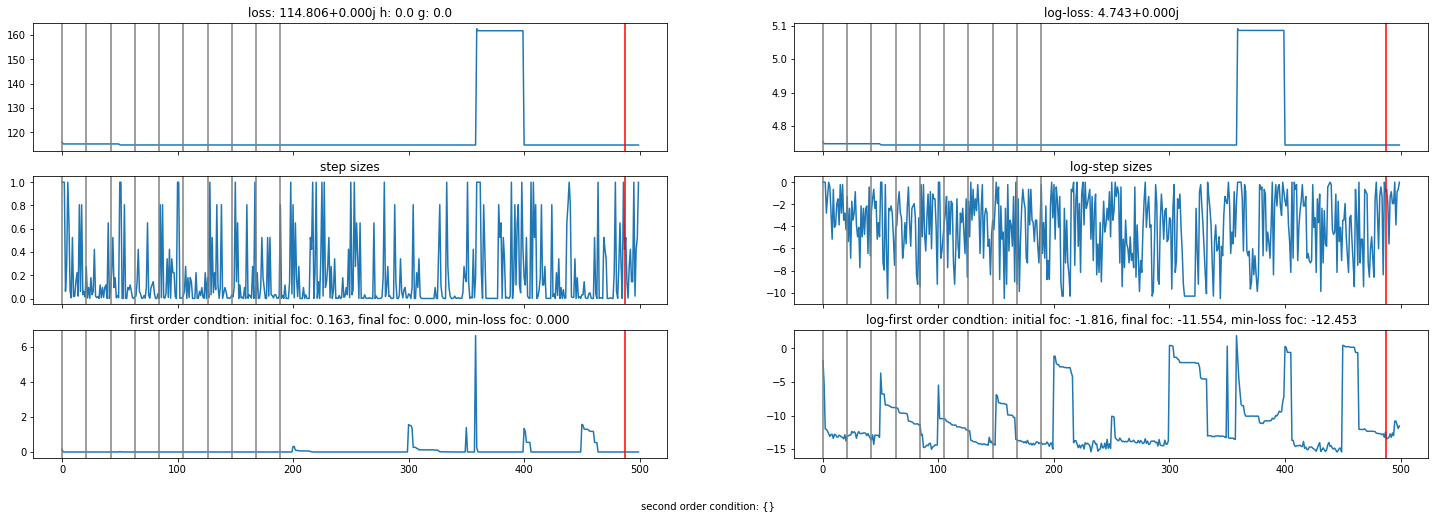

In [9]:
resgraph = utils.plot_results(trace)

In [10]:
voxel_id, voxel_bound = voxel_cluster(X_k, np.array([5, 5]))

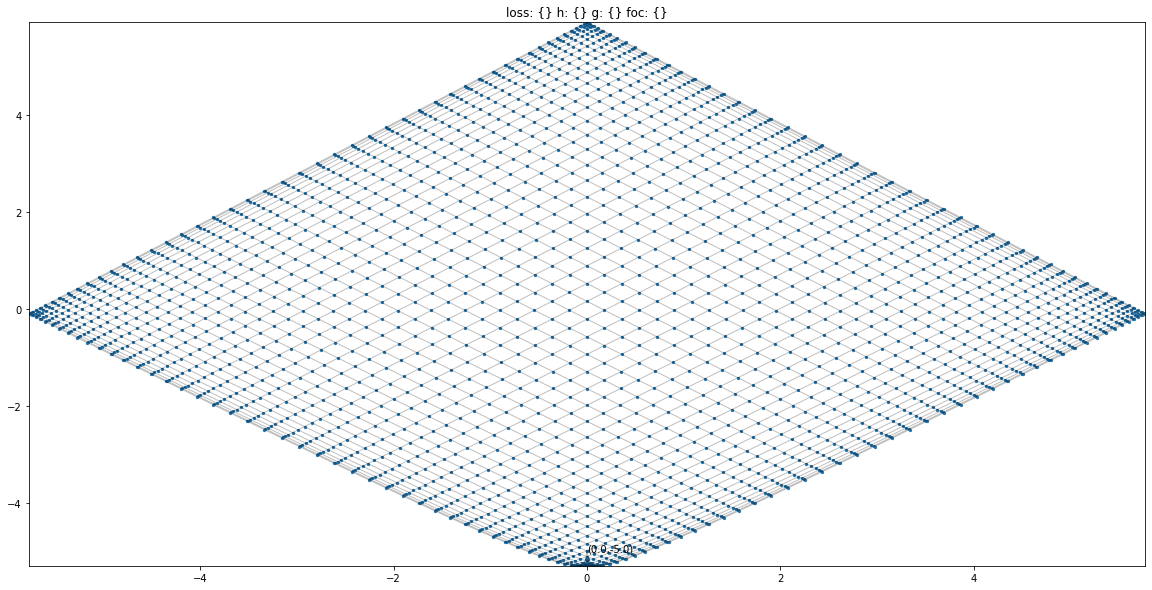

In [11]:
utils.plot_graph(X, graph, title='loss: {} h: {} g: {} foc: {}', fixed_indices=fixed_indices, c=None)